In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6b as of

import tensorflow as tf

import gc


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
ndim = 2

##-------------

train_mu = [ 0.0, 1.0 ]



train_rho = [ [-0.6] ]






train_sig = [ 1.0, 1.5 ]


##-------------


true_mu = [ 0.2, 0.8 ]






true_rho  = [ [-0.6] ]



true_sig = [ 0.9, 1.3 ]



#--- nominal
resolution = [ 0.5, 0.8  ]

#--- poor
#resolution = [ 1.0, 1.6  ]




train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                



ngen_train = 4000000
ngen_true =  400000



of_niter = 5




learning_rate_setval = 0.0005


epochs_setval = 40

batch_size_setval = int( ngen_true )





n_boot_samples = 100

do_bootstrap = True


output_dir = 'output-files-bootstrap-test6b-2d'








 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    1.500 *   -0.600 =  -0.9000
   1,  1 : diagonal    2.2500



 True covariance:
   0,  0 : diagonal    0.8100
   0,  1 :              0.900 *    1.300 *   -0.600 =  -0.7020
   1,  1 : diagonal    1.6900


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    print('\n\n HALTING EXECUTION\n\n')
    sys.exit()

In [5]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )

In [6]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )
config_file.write('n_boot_samples  %d\n' % n_boot_samples )
config_file.write('do_bootstrap  %d\n' % do_bootstrap )
config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : output-files-bootstrap-test6b-2d/config.txt

2023-12-14 16:20:25.015690

ngen_train 4000000
ngen_true  400000
of_niter   5
ndim       2
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  400000
n_boot_samples  100
do_bootstrap  1


train_mu : [0.0, 1.0]
train_rho : [[-0.6]]
train_sig : [1.0, 1.5]


true_mu : [0.2, 0.8]
true_rho : [[-0.6]]
true_sig : [0.9, 1.3]


resolution : [0.5, 0.8]





In [7]:
train_det = np.linalg.det( train_cov )
true_det  = np.linalg.det( true_cov )

In [8]:
print("\n\n")
print("Train covariance determinant:  %f" % train_det )
print("True covariance determinant:   %f" % true_det )
print("\n\n")




Train covariance determinant:  1.440000
True covariance determinant:   0.876096





In [9]:
if train_det < 0 :
    print('\n\n negative determinant!')
    print('\n\n HALTING EXECUTION\n\n')
    sys.exit()    

In [10]:
if true_det < 0 :
    print('\n\n negative determinant!')
    print('\n\n HALTING EXECUTION\n\n')
    sys.exit()    

In [11]:
train_cov_inv = np.linalg.inv( train_cov )

In [12]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [13]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.   -0.9 ]
 [-0.9   2.25]]

 Train covariance inverse
[[1.5625     0.625     ]
 [0.625      0.69444444]]

 Train covariance inverse test
[[ 1.00000000e+00 -3.82410153e-17]
 [-5.55111512e-17  1.00000000e+00]]





In [14]:
true_cov_inv = np.linalg.inv( true_cov )

In [15]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [16]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.81  -0.702]
 [-0.702  1.69 ]]

 True covariance inverse
[[1.92901235 0.80128205]
 [0.80128205 0.92455621]]

 True covariance inverse test
[[ 1.00000000e+00  3.80221824e-17]
 [-5.90695584e-17  1.00000000e+00]]





## Generate the samples

In [17]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



In [18]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)


## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

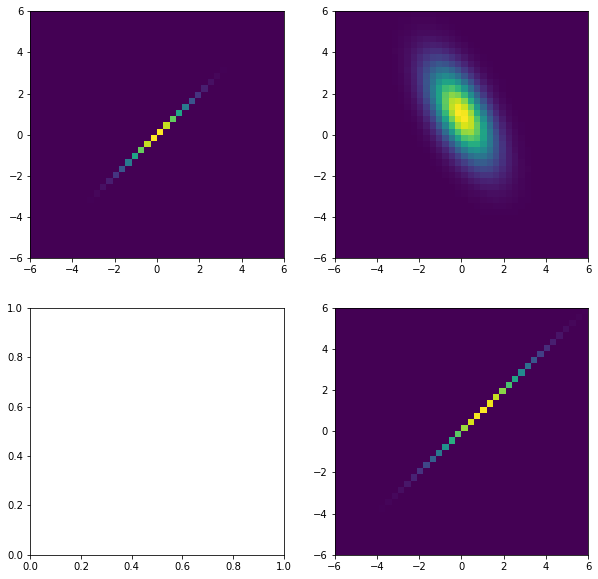

In [19]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))


hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

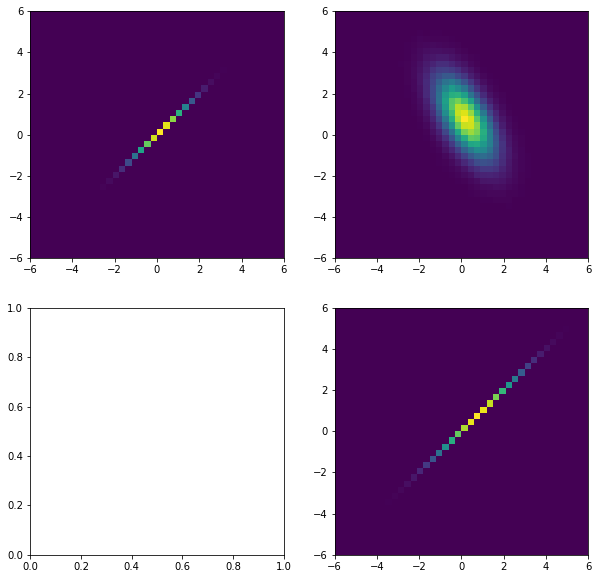

In [20]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))


hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

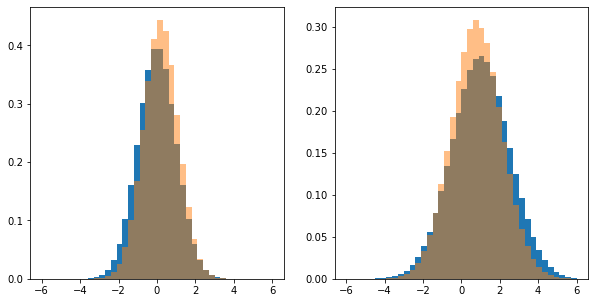

In [21]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))
hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [22]:
inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-14 16:20:27.181532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:20:27.206715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:20:27.207011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:20:27.210796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:20:27.211040: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [23]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [ ]:
%%time


verbose = True






of_return_dict = of.omnifold6b( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval,
    True, output_dir )

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights


with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)
    




  ======== omnifold6b


  shape of theta0_S : (4000000, 2)
  shape of theta_unknown_S : (400000, 2)
  shape of xvals_1 :  (4400000, 2)



  shape of labels0 : (4000000,)
  shape of labels_unknown : (400000,)
  shape of yvals_1 :  (4400000,)



  shape of theta0_G : (4000000, 2)
  shape of xvals_2 :  (8000000, 2)
  shape of yvals_2 :  (8000000,)

 batch size setval  400000
 learning rate setval  0.000500
 epochs setval  40




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5


2023-12-14 16:20:31.422614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-14 16:20:31.426821: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb72f890c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 16:20:31.426834: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-14 16:20:31.430763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-14 16:20:31.529350: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 2s 8ms/step - loss: 0.6966 - accuracy: 0.5490
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.3912
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.3482
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4480
Epoch 5/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4362
             done pretraining.
Epoch 1/80
9/9 [==============================] - 1s 27ms/step - loss: 0.1258 - accuracy: 0.4144 - val_loss: 0.1256 - val_accuracy: 0.4232
Epoch 2/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1254 - accuracy: 0.4059 - val_loss: 0.1254 - val_accuracy: 0.3659
Epoch 3/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1252 - accuracy: 0.3434 - val_loss: 0.1252 - val_accuracy: 0.3153
Epoch 4/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1250

Epoch 56/80
9/9 [==============================] - 0s 16ms/step - loss: 0.1244 - accuracy: 0.2555 - val_loss: 0.1246 - val_accuracy: 0.2583
Epoch 57/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1244 - accuracy: 0.2555 - val_loss: 0.1246 - val_accuracy: 0.2556
Epoch 58/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.2561 - val_loss: 0.1246 - val_accuracy: 0.2554
Epoch 59/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2554 - val_loss: 0.1246 - val_accuracy: 0.2574
Epoch 60/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.2569 - val_loss: 0.1246 - val_accuracy: 0.2528
Epoch 61/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2536 - val_loss: 0.1246 - val_accuracy: 0.2572
Epoch 62/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2566 - val_loss: 0.1246 - val_accuracy: 0.2531
Epoch 63/80
9/9 [===

15/15 [==============================] - 0s 12ms/step - loss: 0.6867 - accuracy: 0.3951 - val_loss: 0.6868 - val_accuracy: 0.3948
Epoch 30/80
15/15 [==============================] - 0s 10ms/step - loss: 0.6867 - accuracy: 0.3951 - val_loss: 0.6868 - val_accuracy: 0.3949
Epoch 31/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6867 - accuracy: 0.3951 - val_loss: 0.6868 - val_accuracy: 0.3949
Epoch 32/80
15/15 [==============================] - 0s 10ms/step - loss: 0.6867 - accuracy: 0.3952 - val_loss: 0.6868 - val_accuracy: 0.3949
Epoch 33/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6867 - accuracy: 0.3953 - val_loss: 0.6868 - val_accuracy: 0.3950
Epoch 34/80
15/15 [==============================] - 0s 10ms/step - loss: 0.6867 - accuracy: 0.3953 - val_loss: 0.6868 - val_accuracy: 0.3950
Epoch 35/80
15/15 [==============================] - 0s 10ms/step - loss: 0.6867 - accuracy: 0.3953 - val_loss: 0.6868 - val_accuracy: 0.3950
Epoch 36/80
15/15 

15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5580
Epoch 5/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5197
             done pretraining.
Epoch 1/40
9/9 [==============================] - 0s 25ms/step - loss: 0.1260 - accuracy: 0.3103 - val_loss: 0.1260 - val_accuracy: 0.3723
Epoch 2/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1260 - accuracy: 0.3889 - val_loss: 0.1259 - val_accuracy: 0.3904
Epoch 3/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1259 - accuracy: 0.3756 - val_loss: 0.1259 - val_accuracy: 0.3530
Epoch 4/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1259 - accuracy: 0.3430 - val_loss: 0.1259 - val_accuracy: 0.3270
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.3178 - val_loss: 0.1259 - val_accuracy: 0.3081
Epoch 6/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1259 - accuracy: 

15/15 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2501
Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2501
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2501
Epoch 16/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2501
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2501
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2501
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6922 - val_accuracy: 0.2501
Epoch 20/40
15/15 

9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2496 - val_loss: 0.1259 - val_accuracy: 0.2475
Epoch 25/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2556 - val_loss: 0.1259 - val_accuracy: 0.2543
Epoch 26/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2451 - val_loss: 0.1259 - val_accuracy: 0.2406
Epoch 27/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2490 - val_loss: 0.1259 - val_accuracy: 0.2493
Epoch 28/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.2393 - val_loss: 0.1259 - val_accuracy: 0.2403
Epoch 29/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2511 - val_loss: 0.1259 - val_accuracy: 0.2555
Epoch 30/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2437 - val_loss: 0.1259 - val_accuracy: 0.2394
Epoch 31/40
9/9 [===============

15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2499 - val_loss: 0.6932 - val_accuracy: 0.2502
Epoch 38/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6931 - accuracy: 0.2499 - val_loss: 0.6932 - val_accuracy: 0.2502
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.2499 - val_loss: 0.6932 - val_accuracy: 0.2502
Epoch 40/40
400/400 [==============================] - 0s 597us/step

 +++ Saving step 2, iteration 2 model in output-files-bootstrap-test6b-2d/of-step2-iter02-model
INFO:tensorflow:Assets written to: output-files-bootstrap-test6b-2d/of-step2-iter02-model/assets

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[1.00421471 1.27048917 0.89218528 ... 1.06758436 1.30648512 1.04664111]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6933 - accuracy: 0.5940
Epoch 2/5
15/15 [======

Epoch 4/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2500
Epoch 5/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2501
Epoch 6/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2501
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2502
Epoch 8/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6925 - accuracy: 0.2499 - val_loss: 0.6924 - val_accuracy: 0.2501
Epoch 9/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2502
Epoch 10/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6925 - accuracy: 0.2499 - val_loss: 0.6924 - val_accuracy: 0.2501
Epoch 11/40


9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.2382 - val_loss: 0.1257 - val_accuracy: 0.2420
Epoch 16/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.2171 - val_loss: 0.1257 - val_accuracy: 0.1975
Epoch 17/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2135 - val_loss: 0.1257 - val_accuracy: 0.2335
Epoch 18/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2295 - val_loss: 0.1257 - val_accuracy: 0.2098
Epoch 19/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2224 - val_loss: 0.1257 - val_accuracy: 0.2228
Epoch 20/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2086 - val_loss: 0.1257 - val_accuracy: 0.2200
Epoch 21/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1258 - accuracy: 0.2463 - val_loss: 0.1257 - val_accuracy: 0.2283
Epoch 22/40
9/9 [===============

In [ ]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



In [ ]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [ ]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


In [ ]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(hist_data_diff[ofi,di])

    
plt.show   

In [ ]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

    
plt.show  

In [ ]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [ ]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,4] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

In [ ]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

In [ ]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    




plt.show

In [ ]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


In [ ]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show   

In [ ]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show  

In [ ]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [ ]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

In [ ]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

## Do the bootstrap samples in a loop

In [ ]:

verbose = False



In [ ]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, [res0, res1])
        

        
    boot_of_return_dict = of.omnifold6b( 
        train_both, boot_true_det_pts, of_niter, model, verbose, 
        batch_size_setval, learning_rate_setval, epochs_setval )


    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    